In [1]:
for i in range(0,1):
    import pybamm as pybamm
    import pandas as pd   
    import numpy as np
    import os
    import matplotlib.pyplot as plt
    from scipy.io import savemat,loadmat
    from pybamm import constants,exp,sqrt
    import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False

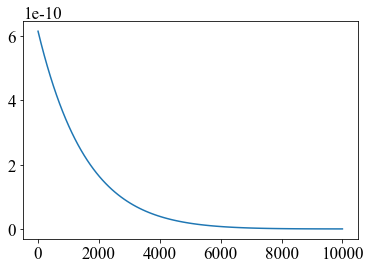

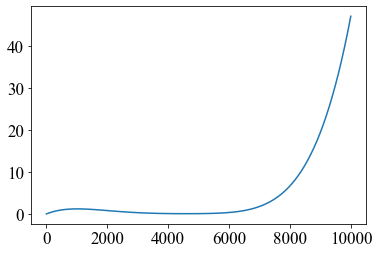

<AxesSubplot:>

In [2]:
ChemistryChen=pybamm.parameter_sets.Chen2020 
ChemistryChen["electrolyte"] = "lipf6_Valoen2005";
Para_0=pybamm.ParameterValues(chemistry=ChemistryChen);
c_e = pybamm.linspace(0, 1e4, 100)
D_e = Para_0["Electrolyte diffusivity [m2.s-1]"]
pybamm.plot(c_e, D_e(c_e, 4541,298.15))
sigma_e = Para_0['Electrolyte conductivity [S.m-1]']
pybamm.plot(c_e, sigma_e(c_e, 4541,298.15))

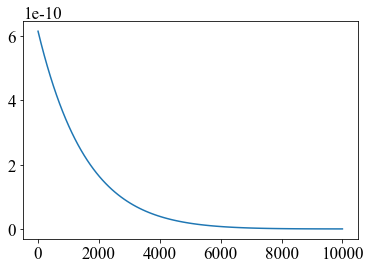

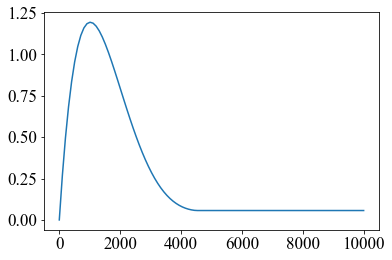

<AxesSubplot:>

In [3]:
ChemistryChen=pybamm.parameter_sets.Chen2020 
ChemistryChen["electrolyte"] = "lipf6_Valoen2005Constant";
Para_0=pybamm.ParameterValues(chemistry=ChemistryChen);
c_e = pybamm.linspace(0, 1e4, 100)
D_e = Para_0["Electrolyte diffusivity [m2.s-1]"]
pybamm.plot(c_e, D_e(c_e, 4541,298.15))
sigma_e = Para_0['Electrolyte conductivity [S.m-1]']
pybamm.plot(c_e, sigma_e(c_e, 4541,298.15))

In [4]:
# Define electrolyte diffusivity and conductivity
def electrolyte_diffusivity_Nyman2008(c_e, T):
    D_c_e = 8.794e-11 * (c_e / 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10
    return D_c_e    
def electrolyte_conductivity_Nyman2008(c_e, T):
    sigma_e = (0.1297 * (c_e / 1000) ** 3 - 2.51 * (c_e / 1000) ** 1.5 + 3.329 * (c_e / 1000))
    return sigma_e

def electrolyte_conductivity_Valoen2005(c_e, T):   # valid concentration: 0~4000 mol/m3
    sigma_e = 0.1 * (-10.5 + 0.668*(1e-3*c_e) + 0.494*(1e-6*c_e**2) + 0.074*T - 0.0178*(1e-3*c_e)*T - 8.86e-4*(1e-6*c_e**2)*T - 6.96e-5*T**2 + 2.8E-5*(1E-3*c_e)*T**2 ) **2 * (1e-3*c_e)
    return sigma_e
def electrolyte_diffusivity_Valoen2005(c_e, T):
    D_c_e = 1e-4 * 10**(-4.43 - 54/(T - 229 - 0.005*c_e) - 2.2e-4 * c_e   )
    return D_c_e

def electrolyte_conductivity_Ecker2015(c_e, T):
    # mol/m^3 to mol/l
    cm = 1e-3 * c_e
    # value at T = 296K
    sigma_e_296 = 0.2667 * cm ** 3 - 1.2983 * cm ** 2 + 1.7919 * cm + 0.1726
    # Add temperature dependence
    E_k_e = 1.71e4
    C = 296 * exp(E_k_e / (constants.R * 296))
    sigma_e = C * sigma_e_296 * exp(-E_k_e / (constants.R * T)) / T
    return sigma_e.value
def electrolyte_diffusivity_Ecker2015(c_e, T):
    # mol/m^3 to mol/l
    cm = 1e-3 * c_e
    # value at T = 296K
    sigma_e_296 = 0.2667 * cm ** 3 - 1.2983 * cm ** 2 + 1.7919 * cm + 0.1726
    # add temperature dependence
    E_k_e = 1.71e4
    C = 296 * exp(E_k_e / (constants.R * 296))
    sigma_e = C * sigma_e_296 * exp(-E_k_e / (constants.R * T)) / T
    D_c_e = (constants.k_b / (constants.F * constants.q_e)) * sigma_e * T / c_e
    return D_c_e.value

def electrolyte_conductivity_Ding2001(c_e, c_EC,  T):
    # c_e is lithium ion concentration in electrolyte in mol/m3, need to change to mol/kg
    # also be careful that T here is deg, while others are K
    rho_electrolyte = 1300 # in kg/m3
    c_e_kg = c_e / rho_electrolyte     # in mol/kg 
    M_LiPF6 = 151.905/1000  # kg/mol
    M_EC = 88.062/1000  # kg/mol
    M_EMC = 104.104/1000 # kg/mol
    x_EC = 1 / (1+ ( rho_electrolyte - c_e*M_LiPF6 - c_EC*M_EC  )/M_EMC/c_EC   )
    kai = -3.37115 + 12.5608*c_e_kg - 7.89593*c_e_kg**2 + 3.51922*c_e_kg**3-1.15471*c_e_kg**4 +18.1863*x_EC - 6.22756*c_e_kg*x_EC - 13.6916*c_e_kg**2*x_EC +8.43904*c_e_kg**3*x_EC - 7.83732*x_EC**2 + 19.607*c_e_kg*x_EC**2  - 18.4529*c_e_kg**2*x_EC**2 -30.6369*x_EC**3 + 29.2*c_e_kg*x_EC**3 - 0.0429918*T + 0.180877*c_e_kg*T -0.0836202*c_e_kg**2*T + 0.0230098*c_e_kg**3*T + 0.195946*T*x_EC +0.0676686*c_e_kg*x_EC*T - 0.14134*c_e_kg**2*x_EC*T + 0.147429*x_EC**2*T  +0.173059*c_e_kg*x_EC**2*T - 0.51634*x_EC**3*T - 0.000223097*T**2 +0.000111233*c_e_kg*T**2 + 0.0000495286*c_e_kg**2*T**2  +0.000952777*x_EC*T**2 + 0.00117334 *c_e_kg*x_EC*T**2-0.000619157*x_EC**2*T**2 - 3.46897E-7*T**3 - 2.75041E-6*c_e_kg*T**3 -5.57653E-6*x_EC*T**3 
    return kai 

In [5]:
np.sqrt(2)

1.4142135623730951

In [6]:
def electrolyte_conductivity_base_Landesfeind2019(c_e, T, coeffs):
    c = c_e / 1000  # mol.m-3 -> mol.l
    p1, p2, p3, p4, p5, p6 = coeffs
    A = p1 * (1 + (T - p2))
    B = 1 + p3 * np.sqrt(c) + p4 * (1 + p5 * np.exp(1000 / T)) * c
    C = 1 + c ** 4 * (p6 * np.exp(1000 / T))
    sigma_e = A * c * B / C  # mS.cm-1

    return sigma_e / 10

def electrolyte_diffusivity_base_Landesfeind2019(c_e, T, coeffs):
    c = c_e / 1000  # mol.m-3 -> mol.l
    p1, p2, p3, p4 = coeffs
    A = p1 * exp(p2 * c)
    B = exp(p3 / T)
    C = exp(p4 * c / T)
    D_e = A * B * C * 1e-10  # m2/s

    return D_e

def electrolyte_TDF_base_Landesfeind2019(c_e, T, coeffs):
    c = c_e / 1000  # mol.m-3 -> mol.l
    p1, p2, p3, p4, p5, p6, p7, p8, p9 = coeffs
    tdf = (
        p1
        + p2 * c
        + p3 * T
        + p4 * c ** 2
        + p5 * c * T
        + p6 * T ** 2
        + p7 * c ** 3
        + p8 * c ** 2 * T
        + p9 * c * T ** 2
    )
    return tdf

def electrolyte_transference_number_base_Landesfeind2019(c_e, T, coeffs):
    c = c_e / 1000  # mol.m-3 -> mol.l
    p1, p2, p3, p4, p5, p6, p7, p8, p9 = coeffs
    tplus = (
        p1
        + p2 * c
        + p3 * T
        + p4 * c ** 2
        + p5 * c * T
        + p6 * T ** 2
        + p7 * c ** 3
        + p8 * c ** 2 * T
        + p9 * c * T ** 2
    )

    return tplus
def electrolyte_conductivity_EC_DMC_1_1_Landesfeind2019(c_e, T):

    coeffs = np.array([7.98e-1, 2.28e2, -1.22, 5.09e-1, -4e-3, 3.79e-3])

    return electrolyte_conductivity_base_Landesfeind2019(c_e, T, coeffs)
def electrolyte_diffusivity_EC_DMC_1_1_Landesfeind2019(c_e, T):

    coeffs = np.array([1.47e3, 1.33, -1.69e3, -5.63e2])

    return electrolyte_diffusivity_base_Landesfeind2019(c_e, T, coeffs)


In [7]:
from numpy import  exp
sigma_ref = 1; k = 1/1000;
c_EC_2  = np.linspace(2000,6000,LinesNmum)
sigma = (1 - exp(-c_EC_2/1000)) * sigma_ref
sigma2 = (1 - exp(-c_EC_2/2000)) * sigma_ref
#coff_exp = exp(k*c_EC_2-1)
fig, ax = plt.subplots(figsize=(4, 2.7), )
ax.plot(c_EC_2,sigma)
ax.plot(c_EC_2,sigma2)
print((1 - exp(-4541/1000)) * sigma_ref)
print((1 - exp(-6000/1000)) * sigma_ref)

NameError: name 'LinesNmum' is not defined

In [ ]:
ce_plot = np.linspace(650, 1950, 10)
LinesNmum = 10; cmap = mpl.cm.get_cmap("cool", LinesNmum) 
c_ec_all = list(np.linspace(10,6000,LinesNmum))
fig, ax = plt.subplots(1,2,figsize=(10, 2.7), )
for i in range(0,LinesNmum):
    y_i ,x_EC = electrolyte_conductivity_Ding2001(ce_plot, c_ec_all[i],  25);
    ax[0].plot(ce_plot,y_i,color=cmap(i))
    ax[1].plot(ce_plot,x_EC,color=cmap(i))
ax[0].set_title("Electrolyte_conductivity",loc='center')
ax[0].set_xlabel("c(Li+)")
ax[0].set_ylabel("conductivity")
ax[1].set_title("Electrolyte_conductivity",loc='center')
ax[1].set_xlabel("x_EC")
ax[1].set_ylabel("x_EC")